In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
class Ex1Func(object):
    
    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        
        if x[0] < 0.5:
            return x[0]**2. +  self.sigma(x[0]) * np.random.randn()
        if x[0] == 0.5:
            return 1.
        if x[0] > 0.5:
            return 2. - (x[0]-0.5) ** 2.

In [3]:
from pyDOE import *

Text(0,0.5,u'$y$')

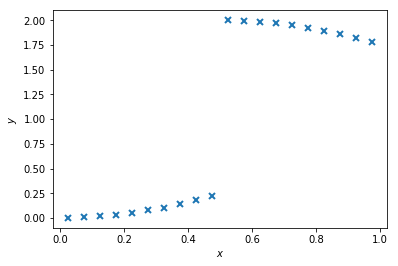

In [4]:
dim = 1
n = 20
noise=0
sigma = eval('lambda x: ' + str(noise))
objective = Ex1Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Y = np.array([objective(x) for x in X])[:, None]
Xnorm = (X - 0.5) / 0.5
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [5]:
#build the model
k = gpflow.kernels.RBF(input_dim=1)
noisekern = gpflow.kernels.RBF(input_dim=1, ARD=True)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptiveLengthscale2D(Xnorm, Y, k, nonstat, noisekern)

In [6]:
m.kerns["ell0"].variance.prior = gpflow.priors.Gamma(1., 1.)
m.kerns["ell0"].lengthscales.prior = gpflow.priors.Gamma(1., 1.)
# m.likelihood.variance = 0.01
# m.likelihood.variance.fixed = True
m.nonstat.signal_variance.prior = gpflow.priors.Gamma(1., 1.)
m.noisekern.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
#m.kern2.variance.prior = gpflow.priors.Gamma(1., 1.)
#m.noisekern.variance = 1e-8
#m.noisekern.variance.fixed = True
m.noisekern.variance.prior = gpflow.priors.Gamma(1., 1.)

In [7]:
m.optimize(maxiter=500) # start near MAP

      fun: array([ 9.09638699])
 hess_inv: <65x65 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.20204498e+01,  -3.20064671e+01,  -1.00394990e+01,
        -2.27672373e+01,  -4.24420074e+01,   3.20415279e+01,
         1.38746402e+01,   3.51001253e+01,  -1.37777978e+01,
         7.53523700e-01,  -7.48147297e-01,   6.69710388e+00,
         1.20421000e+00,   2.95119217e+00,   1.03945942e-01,
        -1.12562924e-01,   1.41356588e+00,  -8.01527040e-01,
        -1.47509440e+01,   1.22697510e-01,   9.38739474e+00,
         7.83499657e+00,   3.75819839e+00,  -7.20476341e-01,
         5.43806594e+00,   1.59818767e+00,   1.12112285e-02,
         4.41727080e-02,  -5.77497771e-03,   2.37033209e-02,
        -3.75219580e-03,  -2.89187877e-03,  -4.85009007e-04,
         8.57633141e-03,   6.29709672e-03,   8.81422895e-04,
         4.19798330e-03,   1.09551424e-04,   2.26837057e-05,
         2.81788230e-04,  -8.76379209e+01,  -1.64814095e+02,
        -7.25850626e+01,  -3.83384440e+01,   

In [9]:
samples = m.sample(500, verbose=True, epsilon=0.00005, thin = 2, burn = 100, Lmax = 160)

burn-in sampling started
Iteration:  100 	 Acc Rate:  87.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  94.0 %
Iteration:  200 	 Acc Rate:  97.0 %
Iteration:  300 	 Acc Rate:  99.0 %
Iteration:  400 	 Acc Rate:  95.0 %
Iteration:  500 	 Acc Rate:  96.0 %
Iteration:  600 	 Acc Rate:  95.0 %
Iteration:  700 	 Acc Rate:  98.0 %
Iteration:  800 	 Acc Rate:  96.0 %
Iteration:  900 	 Acc Rate:  99.0 %
Iteration:  1000 	 Acc Rate:  97.0 %


In [10]:
sample_df = m.get_samples_df(samples)
xnew = np.linspace(0, 1, 50)[:,None]
xx = (xnew - 0.5) / 0.5
mean_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
mean_n_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (sample_df.shape[0], xx.shape[0]))

In [11]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(xx)
    mean_f_mat[i, :] = mean_f[:, 0]
    var_f_mat[i, :] = np.diag(var_f)
    mean_n, var_n = m.predict_n(xx)
    mean_n_mat[i, :] = np.exp(mean_n[:, 0]) ** 2

In [12]:
np.sqrt(mean_n_mat[0,:])

array([  1.83003375e-04,   1.98071234e-04,   2.30736381e-04,
         2.88786289e-04,   3.86991830e-04,   5.52433480e-04,
         8.34517024e-04,   1.32341064e-03,   2.18310276e-03,
         3.70833563e-03,   6.41675091e-03,   1.11842792e-02,
         1.94143799e-02,   3.31885542e-02,   5.52718858e-02,
         8.87676527e-02,   1.36207051e-01,   1.98041862e-01,
         2.70938294e-01,   3.46784781e-01,   4.13484262e-01,
         4.57966643e-01,   4.70533956e-01,   4.48507088e-01,
         3.97210867e-01,   3.27779552e-01,   2.53064178e-01,
         1.83756556e-01,   1.26280226e-01,   8.27192992e-02,
         5.20562703e-02,   3.17393917e-02,   1.89158736e-02,
         1.11200165e-02,   6.50755734e-03,   3.82567113e-03,
         2.27933714e-03,   1.38796403e-03,   8.70630083e-04,
         5.66622290e-04,   3.85058747e-04,   2.74731754e-04,
         2.06721559e-04,   1.64607720e-04,   1.39035399e-04,
         1.24727074e-04,   1.18860570e-04,   1.20222759e-04,
         1.28828547e-04,

In [13]:
std_f_mat = np.sqrt(var_f_mat)
Lowerf = mean_f_mat - 2 * std_f_mat
Upperf = mean_f_mat + 2 * std_f_mat

In [14]:
def visualize(Xgrid, Mgrid, Vargrid, noise_var):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    Sd_noise = np.sqrt(noise_var) 
    Sd_epis = np.sqrt(Vargrid)
    
    lower = Mgrid - 2. * Sd_epis
    upper = Mgrid + 2. * Sd_epis
    
    lower1 = lower - 2. * Sd_noise
    upper1 = upper + 2. * Sd_noise
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, Mgrid, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], lower, upper,
                     color = 'b', alpha = 0.05)
    plt.fill_between(Xgrid[:,0], lower1, upper1,
                    color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [15]:
X_true = np.linspace(0, 1, 100)[:,None]
Y_true = np.array([objective(x) for x in X_true])[:, None]

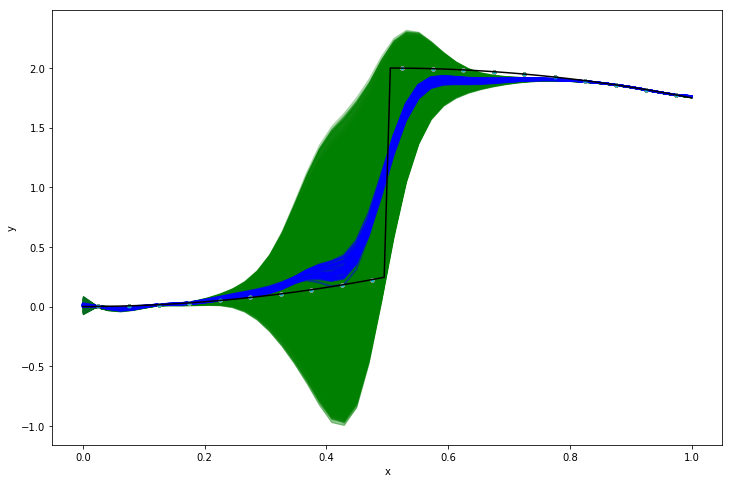

In [18]:
mini = 250
maxi = 300
plt.figure(figsize=(12, 8))

for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], var_f_mat[i,:], noise_var=mean_n_mat[i,:])  
plt.plot(X_true, Y_true, 'k')

In [19]:
def visualize_l(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

In [20]:
mini = 100
maxi = 200
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_l(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

NameError: name 'MeanL' is not defined

In [ ]:
m.predict_f_samples(xx, 100).shape